Импорт необходимых библиотек и определение функции для визуализации данных

In [5]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

Загрузка сейсмических данных

In [6]:
for dirname, _, filenames in os.walk('Downloads/archive/Seismic_data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_53_37-images (21) - Windows Photo Viewer.jpg
Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_53_46-images (21) - Windows Photo Viewer.jpg
Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_54_38-images (23) - Windows Photo Viewer.jpg
Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_54_56-images (24) - Windows Photo Viewer.jpg
Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_55_07-images (24) - Windows Photo Viewer.jpg
Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_55_24-images (25) - Windows Photo Viewer.jpg
Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_55_40-images (26) - Windows Photo Viewer.jpg
Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_56_03-images (28) - Windows Photo Viewer.jpg
Downloads/archive/Seismic_data\test\anticline\2020-07-24 13_56_53-some-machine-learning-applications-in-seismic-interpretation-hero - Windows Phot.jpg
Downloads

In [7]:
pwd

'C:\\Users\\PC'

In [2]:
#импортитруем библиотеки и пути к данным

import tensorflow as tf
import keras
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.preprocessing import image
import os
import matplotlib.pyplot as plt

data_dir = 'Downloads/archive/'
base_dir = 'Downloads/archive/Seismic_data'

# создаем обучающий, валидационный и тестовый наборы

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [3]:
train_dir

'Downloads/archive/Seismic_data\\train'

Функция для визуализации модели

In [4]:
def model_plots(history):
    history_dict = history.history

    # визуализация histories

    epochs = history.epoch
    epochs = epochs[1:]
    epochs.append(len(epochs)+1)
    
    ## обучающий loss и acc
    acc = history_dict['acc']
    loss = history_dict['loss']
    
    ## валидационный loss и acc
    val_acc = history_dict['val_acc']
    val_loss = history_dict['val_loss']
    
    plt.figure("Losses")
    plt.plot(epochs, loss, 'ro-', label='Training loss')
    plt.plot(epochs, val_loss, 'g--', label='Validation loss')
    plt.legend()
    plt.title("Training and Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.show()
    
    
    plt.figure("Accuracy")
    plt.plot(epochs, acc, 'ro-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'g--', label='Validation accuracy')
    plt.legend()
    plt.title("Training and Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

Построение модели

Обучение модели на целевом размере изображений 250х250

In [5]:
# Устанавливаем размер изображений для обработки
x_dim = 250
y_dim = 250

# задаём последовательно связанные между собой слои, Sequential Model
inputs = keras.Input(shape=(x_dim,y_dim,3))
x = layers.Conv2D(64, (4,4), activation='relu', padding='same')(inputs) #первый сверточный слой с 64 фильтрами с ядрами 4х4 пиксела, параметр padding=’same’ означает, что выходная карта признаков на каждом канале должна быть той же размерностью, что и исходное изображение
x = layers.Conv2D(64, (4,4), activation='relu', padding='same')(x)
x = layers.MaxPooling2D(2,2)(x) # слой укрупняет масштаб полученных признаков, pool_size – размер окна, в котором выбирается максимальное значение
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.Conv2D(128, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Conv2D(256, (3,3), activation='relu')(x)
x = layers.Conv2D(256, (3,3), activation='relu')(x)
x = layers.MaxPooling2D(2,2)(x)
x = layers.Flatten()(x) # слой вытягивает полученный тензор в единый вектор
x = layers.Dense(64, activation='relu')(x)  #создаем первый скрытый слой с указанием функции активации 
x = layers.Dropout(0.4)(x) # слой для прореживания 
x = layers.Dense(32, activation='relu')(x)#создаем второй скрытый слой
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(4,activation='softmax')(x) #создаем выходной скрытый слой, состоящий из 4 нейронов с функцией активации SoftMax
model = Model(inputs, outputs)
model.summary() # выводим структуру сети и число весовых коэффициентов в каждом слое

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 64)      3136      
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 64)      65600     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 125, 125, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 123, 123, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 121, 121, 128)     147584    
                                                             

Скомпилируем модель и создадим сгенерированные данные

In [6]:
#гиперпараметры
lr_rate = 1e-3 # скорость обучения
batchSize = 32 # количество образцов, которые будут распространяться по сети

# метрика качества модели
model.compile(
    optimizer = optimizers.RMSprop(learning_rate=lr_rate),
    loss = 'categorical_crossentropy', # функция потерь categorical_crossentropy используется для задач классификации
    metrics=['acc'] #посчитаем долю правильно сделанных прогнозов
    )

# создадим обучающий и тестовый генератор данных
train_datagen = image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,  
    fill_mode="nearest"
    )
test_datagen = image.ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(x_dim,y_dim),
    batch_size=batchSize,
    seed = 56,
    class_mode='categorical'
    )
validation_gen = test_datagen.flow_from_directory(
    directory=validation_dir,
    target_size=(x_dim,y_dim),
    batch_size=batchSize,
    seed = 56,
    class_mode='categorical'
    )

Found 238 images belonging to 4 classes.
Found 50 images belonging to 4 classes.


Визуализация примеров обучающей выборки

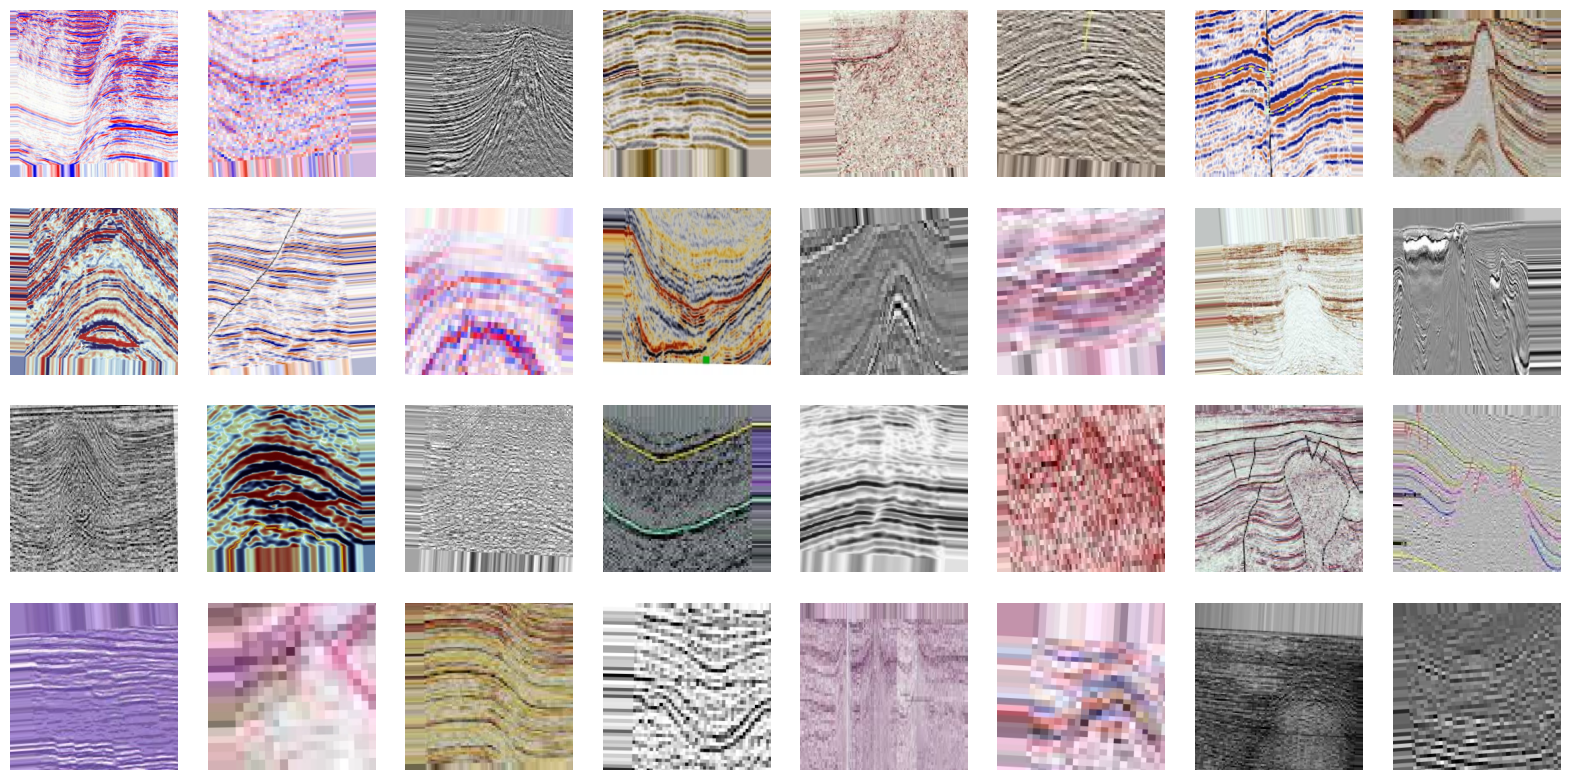

In [7]:
from mpl_toolkits.axes_grid1 import ImageGrid
import math
%matplotlib inline
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # создаем сетку осей размером 2х2
                     axes_pad=0.3,  # расстояние между осями
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # на каждой итерации заполним соответствующее пространство картинкой, объект AxesGrid работает как список осей
        ax.axis('off')
        if show_labels:
            ax.set_title(class_mapping[y_int[i]]) #укажем какому классу соответствует изображение
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

x,y = next(train_gen)
show_grid(x,4,8,figsize=(20,10))  #создадим пространство для восьми картинок в четыре ряда


Обучение модели

C:\Users\PC\AppData\Local\Temp\ipykernel_18748\3904698638.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/30
8/8 [==============================] - 571s 70s/step - loss: 3.8375 - acc: 0.3235 - val_loss: 1.3660 - val_acc: 0.3000
Epoch 2/30
8/8 [==============================] - 528s 66s/step - loss: 1.3732 - acc: 0.2857 - val_loss: 1.3579 - val_acc: 0.3000
Epoch 3/30
8/8 [==============================] - 530s 66s/step - loss: 1.3807 - acc: 0.2941 - val_loss: 1.3668 - val_acc: 0.3000
Epoch 4/30
8/8 [==============================] - 525s 65s/step - loss: 1.3530 - acc: 0.3109 - val_loss: 1.3531 - val_acc: 0.3000
Epoch 5/30
8/8 [==============================] - 524s 65s/step - loss: 1.3720 - acc: 0.2815 - val_loss: 1.3555 - val_acc: 0.3000
Epoch 6/30
8/8 [==============================] - 34746s 4954s/step - loss: 1.3577 - acc: 0.2983 - val_loss: 1.3503 - val_acc: 0.3000
Epoch 7/30
8/8 [==============================] - 541s 73s/step - loss: 1.3683 - acc: 0.2437 - val_loss: 1.3595 - val_acc: 0.3000
Epoch 8/30
8/8 [==============================] - 546s 68s/step - loss: 1.3644 - acc: 

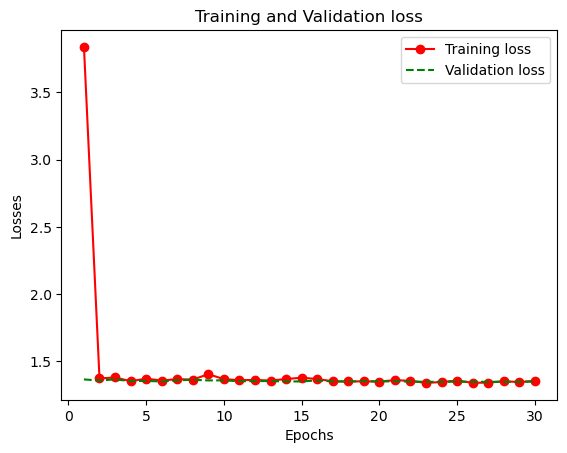

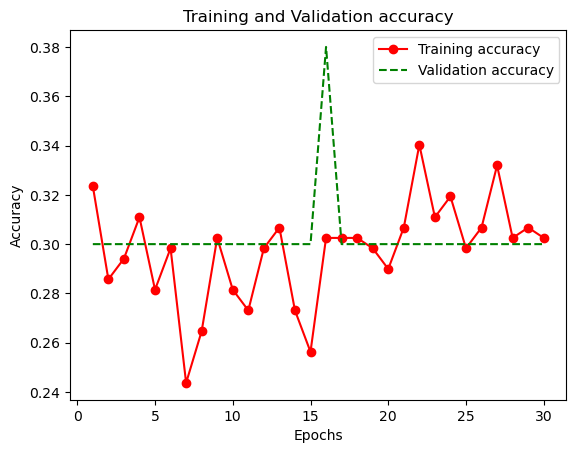

In [8]:
tf.autograph.experimental.do_not_convert

# обучим модель и сохраним историю в переменной history
history = model.fit_generator(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=30, # сколько раз алгоритм обучения будет работать во всем наборе обучающих данных
    validation_data=validation_gen,
    validation_steps=len(validation_gen)
    )

# нарисуем history модели, используя функцию model_plots
model_plots(history)

Создание генератора тестовых данных

In [9]:
test_gen = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(x_dim,y_dim),
    class_mode='categorical'
)

Found 58 images belonging to 4 classes.


Тестирование набора данных, проверка точности на тестовом множестве

In [10]:
test_scores = model.evaluate_generator(test_gen)
print("Test loss:", test_scores[0]) # функция потерь
print("Test accuracy:", test_scores[1]) # точность

C:\Users\PC\AppData\Local\Temp\ipykernel_18748\93224061.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  test_scores = model.evaluate_generator(test_gen)


Test loss: 1.3483374118804932
Test accuracy: 0.3103448152542114


In [11]:
for layer in model.layers:
    # проверяем сверточный слой
    if 'conv' not in layer.name:
        continue
    # получаем веса фильтров
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d (4, 4, 3, 64)
conv2d_1 (4, 4, 64, 64)
conv2d_2 (3, 3, 64, 128)
conv2d_3 (3, 3, 128, 128)
conv2d_4 (3, 3, 128, 256)
conv2d_5 (3, 3, 256, 256)


In [12]:
x,y = next(test_gen)

Визуализация первых 64 каналов скрытых слоёв

1/1 [==============================] - 1s 676ms/step


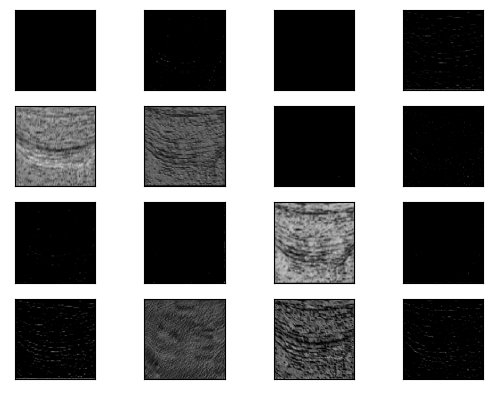

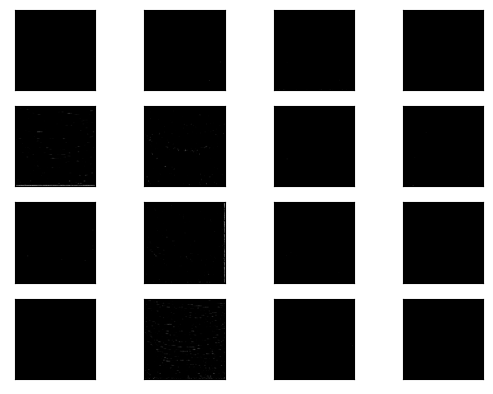

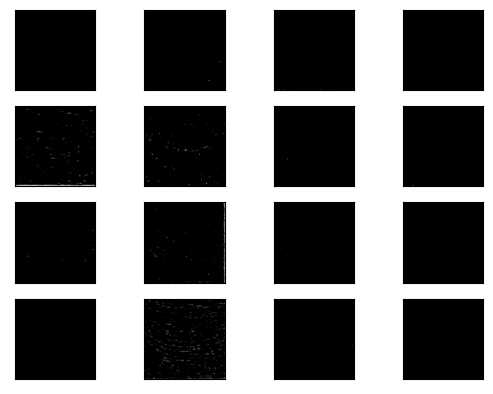

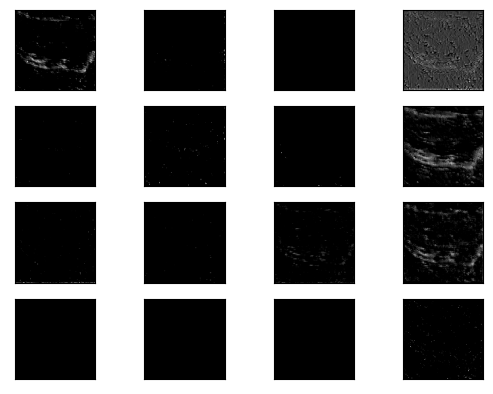

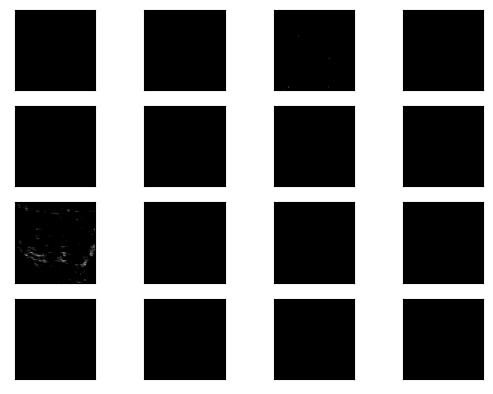

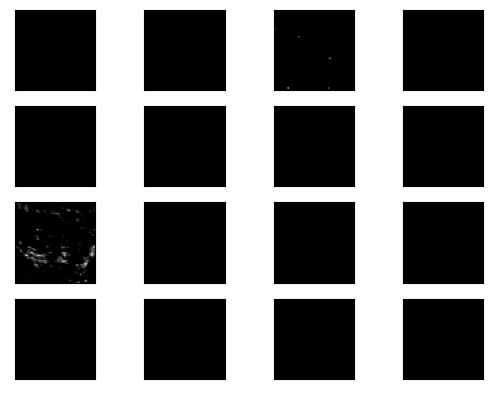

In [14]:
import numpy as np
ixs = [1,2,3,4,5,6]
outputs = [model.layers[i].output for i in ixs]
seis_model = Model(inputs=model.inputs, outputs=outputs)
# конвертируем изображение в массив
img = x[0]
# разворачиваем размеры так, чтобы они представляли собой единый "образец"
img = np.expand_dims(img, axis=0)
# подготавливаем изображение (например, масштабируем значения пикселей)
feature_maps = seis_model.predict(img)
# строим график выходных данных для каждого блока
square = 4
for fmap in feature_maps:
    # визуализируем все 64 карты на квадраты 8х8
    ix = 1
    for _ in range(square):
        for _ in range(square):
            # подзаголовок и поворот оси
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # отображение канала фильтра в оттенках серого
            plt.imshow(fmap[0, :, :, ix-1], cmap='gray')
            ix += 1
    
    plt.show()

Вывод
Модель показывает нам точность тестирования 31% и потери при тестировании 1,35, модель может быть повторно обучена с другими архитектурами и гиперпараметрами



